In [683]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [684]:
df = pd.read_csv('data/heart.csv')

In [685]:
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.0,289.0,0.0,Normal,172.0,N,0.0,Up,0
1,49,F,NAP,160.0,NaN,0.0,Normal,156.0,N,1.0,Flat,1
2,37,M,ATA,130.0,NaN,0.0,ST,98.0,N,0.0,Up,0
3,48,F,ASY,138.0,214.0,0.0,Normal,108.0,Y,1.5,Flat,1
4,54,M,NAP,150.0,195.0,0.0,Normal,122.0,N,0.0,Up,0
5,39,M,NAP,120.0,339.0,0.0,Normal,170.0,N,0.0,Up,0
6,45,F,ATA,130.0,237.0,0.0,Normal,NaN,N,0.0,Up,0
7,54,M,ATA,110.0,NaN,NaN,Normal,142.0,N,0.0,Up,0
8,37,M,ASY,140.0,207.0,0.0,Normal,130.0,Y,1.5,Flat,1
9,48,F,NaN,120.0,284.0,0.0,Normal,120.0,N,0.0,Up,0


In [686]:
df.isna().sum()

Age                0
Sex                0
ChestPainType     15
RestingBP         79
Cholesterol       54
FastingBS          5
RestingECG         0
MaxHR              8
ExerciseAngina     5
Oldpeak            0
ST_Slope          10
HeartDisease       0
dtype: int64

In [687]:
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease'].values

In [688]:
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.70, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.20)


Rzućmy okiem na atrybuty kategotyczne:

In [689]:
X_train['Sex'].value_counts()

M    495
F    147
Name: Sex, dtype: int64

In [690]:
X_train['ChestPainType'].value_counts()

ASY    348
NAP    135
ATA    121
TA      27
Name: ChestPainType, dtype: int64

In [691]:
X_train['FastingBS'].value_counts()

0.0    501
1.0    139
Name: FastingBS, dtype: int64

In [692]:
X_train['RestingECG'].value_counts()

Normal    385
LVH       131
ST        126
Name: RestingECG, dtype: int64

In [693]:
X_train['ExerciseAngina'].value_counts()

N    376
Y    262
Name: ExerciseAngina, dtype: int64

In [694]:
X_train['ST_Slope'].value_counts()

Flat    323
Up      272
Down     38
Name: ST_Slope, dtype: int64

Zbudujmy pipeline preprocessingu:

In [695]:
from sklearn.base import BaseEstimator, TransformerMixin
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Pipeline dla atrybutów numerycznych:

In [696]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(['RestingBP', 'Cholesterol', 'MaxHR'])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

Pipeline dla atrybutów kategorycznych:

In [697]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [698]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

Pierwszy z modeli, który weźmiemy pod uwagę to Random Forest:

In [699]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [700]:
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', RandomForestClassifier())])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [6, 7, 8],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__random_state': [0]
}


In [701]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

grid_search1 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search1.fit(X_train, y_train)
grid_search1.best_params_
ypred = grid_search1.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [702]:
print("Accuracy: ", accuracy)

Accuracy:  0.9107142857142857


In [703]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        21
           1       0.94      0.91      0.93        35

    accuracy                           0.91        56
   macro avg       0.90      0.91      0.91        56
weighted avg       0.91      0.91      0.91        56



<Axes: >

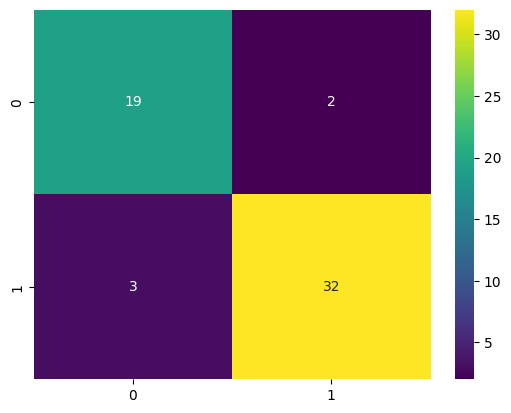

In [704]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

SVM z jądrem rbf:

In [705]:
from sklearn.svm import SVC

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', SVC(kernel='rbf'))])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10 ,100, 1000],
}

In [706]:
grid_search2 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search2.fit(X_train, y_train)
grid_search2.best_params_
ypred = grid_search2.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [707]:
print("Accuracy: ", accuracy)

Accuracy:  0.9285714285714286


SVM z jądem poly:

In [708]:
from sklearn.svm import SVC

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', SVC(kernel='poly'))])

param_grid = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__gamma': [0.01, 0.1, 1]
}

In [709]:
grid_search3 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search3.fit(X_train, y_train)
grid_search3.best_params_
ypred = grid_search3.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [710]:
print("Accuracy: ", accuracy)

Accuracy:  0.9107142857142857


XGBClassifier:

In [711]:
import xgboost

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', xgboost.XGBClassifier())])

param_grid = {
    'classifier__n_estimators': [2, 5, 10, 20],
    'classifier__learning_rate': [0.5, 1, 0.1, 2]
}

In [712]:
grid_search4 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search4.fit(X_train, y_train)
grid_search4.best_params_
ypred = grid_search4.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [713]:
print("Accuracy: ", accuracy)

Accuracy:  0.9107142857142857


In [714]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score


models = []
models.append(('RandomForest', grid_search1.best_estimator_))
models.append(('SVM rbf', grid_search2.best_estimator_))
models.append(('SVM poly', grid_search3.best_estimator_))
models.append(('XGBoost', grid_search4.best_estimator_))


precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_score = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    print("roc_score: {}".format( roc_auc_score(y_test, model.predict(X_test))))
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
    roc_score.append(roc_auc_score(y_test, model.predict(X_test)))

RandomForest
R^2: 0.9411764705882353
recall_score: 0.9142857142857143
f1_score: 0.9275362318840579
accuracy_score: 0.9107142857142857
roc_score: 0.9095238095238095
SVM rbf
R^2: 0.9428571428571428
recall_score: 0.9428571428571428
f1_score: 0.9428571428571428
accuracy_score: 0.9285714285714286
roc_score: 0.9238095238095237
SVM poly
R^2: 0.9411764705882353
recall_score: 0.9142857142857143
f1_score: 0.9275362318840579
accuracy_score: 0.9107142857142857
roc_score: 0.9095238095238095
XGBoost
R^2: 0.9411764705882353
recall_score: 0.9142857142857143
f1_score: 0.9275362318840579
accuracy_score: 0.9107142857142857
roc_score: 0.9095238095238095


In [715]:
d = {
    'precision score': precision_score,
    'recall score': recall_score,
    'f1 score': f1_score,
    'accuracy score': accuracy_score,
    'roc score': roc_score 
}

df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['RandomForest', 'SVM rbf', 'SVM poly', 'XGBoost'])
df

,Method,precision score,recall score,f1 score,accuracy score,roc score
0,RandomForest,0.941176,0.914286,0.927536,0.910714,0.909524
1,SVM rbf,0.942857,0.942857,0.942857,0.928571,0.923810
2,SVM poly,0.941176,0.914286,0.927536,0.910714,0.909524
3,XGBoost,0.941176,0.914286,0.927536,0.910714,0.909524


In [716]:
X_train.shape

(642, 11)

Sieci neuronowe:

In [717]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History

In [718]:
history = History()
model = Sequential()
model.add(Dense(32,activation="relu", input_shape=(19,)))
model.add(Dense(24,activation="relu"))
model.add(Dense(24,activation="relu"))
model.add(Dense(24,activation="relu"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 32)                640       
                                                                 
 dense_95 (Dense)            (None, 24)                792       
                                                                 
 dense_96 (Dense)            (None, 24)                600       
                                                                 
 dense_97 (Dense)            (None, 24)                600       
                                                                 
 dense_98 (Dense)            (None, 1)                 25        
                                                                 
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________


In [719]:
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])


In [720]:
pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('model', model)])

In [721]:
X_test.shape

(56, 11)

In [722]:
# X_val, _, y_val, _ = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# y_val.shape



In [723]:
preprocess_pipeline.fit(X_valid)
X_valid_transformed = preprocess_pipeline.transform(X_valid)
scaler = StandardScaler()
scaler.fit(X_valid_transformed)
X_valid_scaled_transformed = scaler.transform(X_valid_transformed)
history = pipe.fit(X_train, y_train, model__validation_data= (X_valid_scaled_transformed, y_valid), model__batch_size=32, model__epochs=50)
# output = pipe.named_steps['preprocessing'].transform(X_train)
# scaler = StandardScaler()
# scaler.fit(output)
# output_scaled = scaler.transform(output)
# chuj = pd.DataFrame(output_scaled)
# chuj.dtypes
# chuj.isnull().sum()

# output1 = pipe.named_steps['preprocessing'].transform(X_test)
# scaler1 = StandardScaler()
# scaler1.fit(output)
# output_scaled1 = scaler1.transform(output)
# type(output_scaled[19][0])

Epoch 1/50


c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


21/21 [==============================] - 1s 14ms/step - loss: 0.6696 - accuracy: 0.6526 - val_loss: 0.6284 - val_accuracy: 0.8091
Epoch 2/50
21/21 [==============================] - 0s 3ms/step - loss: 0.5809 - accuracy: 0.7944 - val_loss: 0.5122 - val_accuracy: 0.8091
Epoch 3/50
21/21 [==============================] - 0s 4ms/step - loss: 0.4721 - accuracy: 0.8349 - val_loss: 0.4168 - val_accuracy: 0.8182
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.4047 - accuracy: 0.8442 - val_loss: 0.3824 - val_accuracy: 0.8273
Epoch 5/50
21/21 [==============================] - 0s 3ms/step - loss: 0.3758 - accuracy: 0.8489 - val_loss: 0.3589 - val_accuracy: 0.8318
Epoch 6/50
21/21 [==============================] - 0s 3ms/step - loss: 0.3616 - accuracy: 0.8520 - val_loss: 0.3578 - val_accuracy: 0.8500
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 0.3516 - accuracy: 0.8520 - val_loss: 0.3487 - val_accuracy: 0.8545
Epoch 8/50
21/21 [============

In [734]:
model.history.history

{'loss': [0.6695572137832642,
  0.5809057950973511,
  0.47205299139022827,
  0.40472620725631714,
  0.37579917907714844,
  0.3616456687450409,
  0.3515947163105011,
  0.3429388105869293,
  0.3348357677459717,
  0.327002614736557,
  0.3214638829231262,
  0.3142451047897339,
  0.3077006936073303,
  0.30144912004470825,
  0.2952147424221039,
  0.29082366824150085,
  0.28452762961387634,
  0.28049027919769287,
  0.27296212315559387,
  0.26783108711242676,
  0.28635460138320923,
  0.26488229632377625,
  0.25645899772644043,
  0.25127533078193665,
  0.2471325397491455,
  0.24179492890834808,
  0.23781165480613708,
  0.2351757287979126,
  0.24145668745040894,
  0.23097868263721466,
  0.22748874127864838,
  0.23353040218353271,
  0.22380226850509644,
  0.21397767961025238,
  0.21732313930988312,
  0.21050740778446198,
  0.2046602964401245,
  0.19838030636310577,
  0.19620628654956818,
  0.19380302727222443,
  0.1872808188199997,
  0.18680904805660248,
  0.1822056621313095,
  0.1869244277477264

In [740]:
#model.predict(X_valid)
x = np.asarray(X_valid).astype(np.float32)
model.predict(x)


ValueError: could not convert string to float: 'M'

In [733]:
print("R^2: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
print("roc_score: {}".format( roc_auc_score(y_test, model.predict(X_test))))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).